In [2]:
import numpy as np
from pathlib import Path

import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LsiModel

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from numpy import array

import re

from pymorphy2 import MorphAnalyzer

# Data reading

In [4]:
docs = ''
train_docs = []
test_docs = []

train_size = 0.9


for text_file in (Path.cwd() / 'texts').iterdir():
    var = np.random.choice(["test", "train"], p=[0.1, 0.9])
    
    if var == 'test':
        with open(str(text_file), encoding="utf-8") as file:
            test_docs.append( file.read())
    if var == 'train':
        with open(str(text_file), encoding="utf-8") as file:
            train_docs.append( file.read())

In [7]:
analyzer = MorphAnalyzer()

C:\Users\Mikhail_Rogov1\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Mikhail_Rogov1\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Mikhail_Rogov1\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Mikhail_Rogov1\AppData\Local\Continuum\anaconda3\envs\nlp_course

In [9]:
def preprocess(docs):
    tokenizer = WhitespaceTokenizer()
    lemmatizer = WordNetLemmatizer()
    
    docs = list(map(str.lower, docs))
    docs_tokenized = list(map(tokenizer.tokenize, docs))
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs_tokenized]
    
    # Lemmatize all words in documents.
    
    docs_lemmatized = [[analyzer.parse(token)[0].normal_form for token in doc] for doc in docs_tokenized]
    
    return docs_lemmatized

In [10]:
%%time
train_docs_processed = preprocess(train_docs)
test_docs_processed = preprocess(test_docs)

Wall time: 45.1 s


In [12]:
dictionary = Dictionary(train_docs_processed)
dictionary.filter_extremes(no_below=20, no_above=0.1)

corpus = [dictionary.doc2bow(doc) for doc in train_docs_processed]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])


Number of unique tokens: 6061
Number of documents: 6897
[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 1), (24, 1), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 4), (44, 1), (45, 2)]]


In [13]:

dictionary.filter_extremes(no_below=20, no_above=0.1)

test_corpus = [dictionary.doc2bow(doc) for doc in test_docs_processed]

# LDA

In [16]:
lda_model = LdaModel(corpus=corpus, num_topics=20, id2word=dictionary)

In [17]:
for i, topic in lda_model.print_topics():
    print(topic)

0.008*"рентгеновский" + 0.008*"атом" + 0.006*"молекула" + 0.006*"гравитационный" + 0.005*"излучение" + 0.005*"химик" + 0.005*"модель" + 0.005*"протез" + 0.005*"чёрный" + 0.004*"изображение"
0.016*"дрон" + 0.010*"беспилотник" + 0.008*"квантовый" + 0.008*"квадрокоптер" + 0.006*"информация" + 0.005*"виртуальный" + 0.005*"социальный" + 0.005*"программный" + 0.005*"компьютер" + 0.005*"алгоритм"
0.025*"робот" + 0.011*"подводный" + 0.008*"оружие" + 0.007*"передача" + 0.007*"сеть" + 0.005*"стандарт" + 0.005*"учение" + 0.005*"беспилотник" + 0.005*"военный" + 0.005*"оснастить"
0.010*"фотография" + 0.007*"снимок" + 0.006*"new" + 0.006*"плутон" + 0.005*"рыбка" + 0.005*"доставка" + 0.005*"космический" + 0.005*"сближение" + 0.004*"земля" + 0.004*"карта"
0.007*"беспилотник" + 0.005*"беспилотный" + 0.005*"военный" + 0.004*"комплекс" + 0.004*"самолёт" + 0.004*"истребитель" + 0.004*"писать" + 0.004*"камера" + 0.003*"летательный" + 0.003*"ракета"
0.018*"двигатель" + 0.010*"самолёт" + 0.006*"пациент" + 0.

In [54]:
test_perplex = []
k_grid = range(2, 200)

for k in k_grid:
    lda_model = LdaModel(
        corpus=corpus,
        num_topics=k,
        id2word=dictionary
    )
    
    test_perplex.append(lda_model.log_perplexity(test_corpus))

In [55]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Estimating perplexity on test fold')

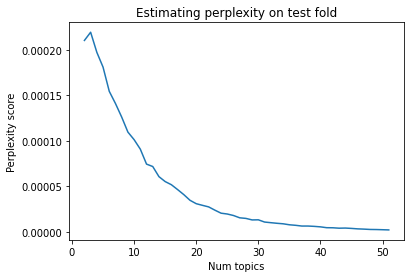

In [60]:
plt.plot(list(k_grid)[:50],
         np.exp(np.asarray(test_perplex))[:50])
plt.xlabel('Num topics')
plt.ylabel('Perplexity score')
plt.title('Estimating perplexity on test fold')

In [ ]:
print(f"Train score :{lda_model.log_perplexity(corpus)}")
print(f"Test score :{lda_model.log_perplexity(test_corpus)}")

# LSI

In [18]:
lsi_model = LsiModel(corpus=corpus,num_topics=20, id2word=dictionary)

In [19]:
for i, topic in lsi_model.print_topics():
    print(topic)

0.200*"самолёт" + 0.108*"–" + 0.101*"беспилотник" + 0.097*"клетка" + 0.090*"двигатель" + 0.086*"беспилотный" + 0.085*"военный" + 0.074*"боевой" + 0.072*"робот" + 0.070*"космический"
-0.480*"самолёт" + -0.166*"беспилотник" + -0.155*"истребитель" + -0.154*"двигатель" + -0.147*"боевой" + -0.144*"военный" + 0.138*"клетка" + 0.121*"–" + -0.120*"беспилотный" + -0.109*"вооружение"
-0.452*"самолёт" + 0.350*"беспилотный" + 0.330*"автомобиль" + -0.245*"клетка" + 0.185*"робот" + 0.152*"беспилотник" + 0.138*"машина" + -0.126*"истребитель" + -0.106*"мозг" + 0.103*"космический"
-0.285*"беспилотный" + -0.264*"автомобиль" + -0.259*"клетка" + 0.180*"звезда" + 0.158*"космический" + 0.152*"квантовый" + 0.148*"самолёт" + 0.142*"планета" + -0.131*"мозг" + 0.122*"частица"
0.551*"робот" + -0.363*"автомобиль" + -0.335*"беспилотный" + -0.279*"самолёт" + 0.168*"корабль" + -0.155*"квантовый" + 0.139*"подводный" + 0.129*"ракета" + -0.108*"дорога" + 0.099*"космический"
0.420*"квантовый" + 0.321*"робот" + 0.207*"ат

In [20]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=test_corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -6.788099293811982


In [21]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lsi_model, corpus=test_corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -8.628906542754333


# SVD

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics.pairwise import cosine_similarity

In [23]:
vectorizer = CountVectorizer(min_df=20, max_df=0.1)
vectorized = vectorizer.fit_transform(list(map(lambda x: ' '.join(x), train_docs_processed)))

vocab = np.asarray(vectorizer.get_feature_names())

In [24]:
n_topics = 30

svd = TruncatedSVD(n_topics)
res = svd.fit_transform(vectorized.T)

In [ ]:
n_words = 30

for topic in range(n_topics):
    print(topic)
    tokens = []
    for token, coef in zip(vocab[np.argsort(res[:,topic])][:n_words][::-1], np.sort(res[:,topic])[::-1]):
        tokens.append(f"{token}: {coef:.2}")
    for token, coef in zip(vocab[np.argsort(res[:,topic])][:n_words], np.sort(res[:,topic])):
        tokens.append(f"{token}: {coef:.2}")
    print(', '.join(tokens))

In [34]:
test_vectorized = vectorizer.transform(list(map(lambda x: ' '.join(x), test_docs_processed)))
sim = cosine_similarity(test_vectorized, res.T)

In [36]:

for i in range(10):
    topics_scores = []
    doc_id = np.random.randint(0, len(test_docs))
    print(doc_id)
    for topic_id, score in enumerate(np.sort(sim[doc_id, :])[::-1][:5]):
        topics_scores.append(f"Topic id:{topic_id}, Score: {score:.2}")

    print(test_docs[doc_id])
    print(topics_scores)
    

622

Физики из коллабораций ATLAS и CMS рассказали о последних результатах поисков частиц вне Стандартной модели на Большом адронном коллайдере. Ученые искали частицы, распадавшиеся на два фотона в данных, собранных за 2016 год. По словам представителей коллаборации ATLAS новые данные не подтверждают избыток фотонов с суммарной энергией 750 гигаэлектронвольт. Аналогичные результаты были получены CMS, на что указывает документ, досрочно опубликованный прошлой ночью.Об этом ученые рассказали в рамках доклада, прошедшего в рамках международной конференции по физике высоких энергий (ICHEP 2016).

['Topic id:0, Score: 0.092', 'Topic id:1, Score: 0.072', 'Topic id:2, Score: 0.071', 'Topic id:3, Score: 0.065', 'Topic id:4, Score: 0.049']
226

Группа специалистов по информационной безопасности shellntel разработала рабочую схему перехвата управления квадрокоптерами с использованием уязвимости в протоколе телеметрии. С подробностями можно ознакомиться в соответствующей записи в блоге разработчи

# Visualiztion

In [37]:
vis = pyLDAvis.gensim.prepare(
    topic_model=lda_model, 
  corpus=corpus, 
  dictionary=dictionary)


In [39]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)
